In [13]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from PIL import Image
from tqdm import tqdm
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.backends.cudnn.deterministic = True

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [14]:
from pathlib import Path
base_dir = Path('../../dataset/lung/Infection Segmentation Data')

train_img_dir = base_dir / 'Train' / 'COVID-19' / 'images'
train_mask_dir = base_dir / 'Train' / 'COVID-19' / 'infection masks'

val_img_dir = base_dir / 'Val' / 'COVID-19' / 'images'
val_mask_dir = base_dir / 'Val' / 'COVID-19' / 'infection masks'

test_img_dir = base_dir / 'Test' / 'COVID-19' / 'images'
test_mask_dir = base_dir / 'Test' / 'COVID-19' / 'infection masks'

print("Checking dataset paths...\n")
paths_to_check = [
    ('Train Images', train_img_dir),
    ('Train Masks', train_mask_dir),
    ('Val Images', val_img_dir),
    ('Val Masks', val_mask_dir),
    ('Test Images', test_img_dir),
    ('Test Masks', test_mask_dir)
]

all_exist = True
for name, path in paths_to_check:
    if path.exists():
        num_files = len(list(path.glob('*.png')))
        print(f"{name:15s}: {path} ({num_files} files)")
    else:
        print(f"{name:15s}: {path} - NOT FOUND")
        all_exist = False

if not all_exist:
    print("WARNING: Some paths do not exist!")
    print("Please verify your dataset location and update the base_dir variable.")
else:
    print("All dataset paths verified successfully!")

Checking dataset paths...

Train Images   : ..\..\dataset\lung\Infection Segmentation Data\Train\COVID-19\images (1864 files)
Train Masks    : ..\..\dataset\lung\Infection Segmentation Data\Train\COVID-19\infection masks (1864 files)
Val Images     : ..\..\dataset\lung\Infection Segmentation Data\Val\COVID-19\images (466 files)
Val Masks      : ..\..\dataset\lung\Infection Segmentation Data\Val\COVID-19\infection masks (466 files)
Test Images    : ..\..\dataset\lung\Infection Segmentation Data\Test\COVID-19\images (583 files)
Test Masks     : ..\..\dataset\lung\Infection Segmentation Data\Test\COVID-19\infection masks (583 files)
All dataset paths verified successfully!


In [15]:
class COVID19Dataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None, img_size=256):
        self.image_dir = Path(image_dir)
        self.mask_dir = Path(mask_dir)
        self.transform = transform
        self.img_size = img_size
        
        self.image_files = sorted(list(self.image_dir.glob('*.png')))
        
        valid_pairs = []
        for img_file in self.image_files:
            mask_file = self.mask_dir / img_file.name
            if mask_file.exists():
                valid_pairs.append(img_file)
        
        self.image_files = valid_pairs
        print(f"Loaded {len(self.image_files)} image-mask pairs from {image_dir.name}")
    
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)
        mask_path = self.mask_dir / img_path.name
        mask = cv2.imread(str(mask_path), cv2.IMREAD_GRAYSCALE)
        
        if image is None:
            raise ValueError(f"Failed to load image: {img_path}")
        if mask is None:
            raise ValueError(f"Failed to load mask: {mask_path}")
        
        image = cv2.resize(image, (self.img_size, self.img_size))
        mask = cv2.resize(mask, (self.img_size, self.img_size))
        
        image = image.astype(np.float32) / 255.0
        mask = mask.astype(np.float32) / 255.0
        
        mask = (mask > 0.5).astype(np.float32)
        
        image = torch.from_numpy(image).unsqueeze(0)
        mask = torch.from_numpy(mask).unsqueeze(0)
        
        if self.transform:
            seed = np.random.randint(2147483647)
            torch.manual_seed(seed)
            image = self.transform(image)
            torch.manual_seed(seed)
            mask = self.transform(mask)
        
        return image, mask

In [16]:
train_dataset = COVID19Dataset(train_img_dir, train_mask_dir, img_size=256)
val_dataset = COVID19Dataset(val_img_dir, val_mask_dir, img_size=256)
test_dataset = COVID19Dataset(test_img_dir, test_mask_dir, img_size=256)

print(f"\nDataset sizes:")
print(f"Train: {len(train_dataset)} samples")
print(f"Validation: {len(val_dataset)} samples")
print(f"Test: {len(test_dataset)} samples")
print(f"Total: {len(train_dataset) + len(val_dataset) + len(test_dataset)} samples")

Loaded 1864 image-mask pairs from images
Loaded 466 image-mask pairs from images
Loaded 583 image-mask pairs from images

Dataset sizes:
Train: 1864 samples
Validation: 466 samples
Test: 583 samples
Total: 2913 samples


In [17]:
batch_size = 8

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=0)

print(f"\nDataLoader batches:")
print(f"Train: {len(train_loader)} batches")
print(f"Validation: {len(val_loader)} batches")
print(f"Test: {len(test_loader)} batches")


DataLoader batches:
Train: 233 batches
Validation: 59 batches
Test: 583 batches


In [18]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.skip = nn.Sequential()
        if in_channels != out_channels:
            self.skip = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1),
                nn.BatchNorm2d(out_channels)
            )
    
    def forward(self, x):
        identity = self.skip(x)
        
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        
        out += identity  
        out = self.relu(out)
        
        return out

In [19]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    
    def forward(self, x):
        return self.double_conv(x)

In [20]:
class UNetResidual(nn.Module):
    def __init__(self, in_channels=1, out_channels=1, features=[16, 32, 64, 128]):
        super().__init__()
        
        self.encoder = nn.ModuleList()
        for feature in features:
            self.encoder.append(ResidualBlock(in_channels, feature))
            in_channels = feature
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.bottleneck = ResidualBlock(features[-1], features[-1]*2)
        
        self.decoder = nn.ModuleList()
        for feature in reversed(features):
            self.decoder.append(
                nn.ConvTranspose2d(feature*2, feature, kernel_size=2, stride=2)
            )
            self.decoder.append(DoubleConv(feature*2, feature))
        
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)
    
    def forward(self, x):
        skip_connections = []
        
        for encode in self.encoder:
            x = encode(x)
            skip_connections.append(x)
            x = self.pool(x)
        
        x = self.bottleneck(x)
        
        skip_connections = skip_connections[::-1]
        
        for idx in range(0, len(self.decoder), 2):
            x = self.decoder[idx](x)  
            skip_connection = skip_connections[idx//2]
            
            if x.shape != skip_connection.shape:
                x = nn.functional.interpolate(x, size=skip_connection.shape[2:])
            
            x = torch.cat((skip_connection, x), dim=1)
            x = self.decoder[idx+1](x)  
        
        return torch.sigmoid(self.final_conv(x))

In [21]:
model = UNetResidual().to(device)
print(f'Model parameters: {sum(p.numel() for p in model.parameters()):,}')

x = torch.randn(1, 1, 256, 256).to(device)
output = model(x)
print(f'Input shape: {x.shape}')
print(f'Output shape: {output.shape}')

Model parameters: 1,988,785
Input shape: torch.Size([1, 1, 256, 256])
Output shape: torch.Size([1, 1, 256, 256])


In [22]:
loss_functions = {
    'BCE': nn.BCELoss(),
    'MSE': nn.MSELoss()
}

print('Loss functions defined:')
for name in loss_functions.keys():
    print(f'  - {name}')

Loss functions defined:
  - BCE
  - MSE


In [23]:
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    
    for images, masks in tqdm(loader, desc='Training', leave=False):
        images = images.to(device)
        masks = masks.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    return total_loss / len(loader)


def validate(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    
    with torch.no_grad():
        for images, masks in loader:
            images = images.to(device)
            masks = masks.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, masks)
            total_loss += loss.item()
    
    return total_loss / len(loader)


def calculate_metrics(pred, target):
    mae = torch.abs(pred - target).mean().item() * 100  
    
    pred_binary = (pred > 0.5).float()
    target_binary = (target > 0.5).float()
    
    intersection = (pred_binary * target_binary).sum().item()
    union = pred_binary.sum().item() + target_binary.sum().item() - intersection
    iou = (intersection + 1e-6) / (union + 1e-6)
    
    return mae, iou

In [24]:
num_epochs = 100
learning_rate = 0.001

models_dict = {}
history = {}

for loss_name, criterion in loss_functions.items():
    print(f"Training with {loss_name} loss function")
    
    model = UNetResidual().to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    train_losses = []
    val_losses = []
    
    for epoch in range(num_epochs):
        train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
        train_losses.append(train_loss)
        
        val_loss = validate(model, val_loader, criterion, device)
        val_losses.append(val_loss)
        
        if (epoch + 1) % 10 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}")
    
    models_dict[loss_name] = model
    history[loss_name] = {
        'train_loss': train_losses,
        'val_loss': val_losses
    }
    
    print(f"  Training completed for {loss_name}")
    print(f"  Final Train Loss: {train_losses[-1]:.6f}")
    print(f"  Final Val Loss: {val_losses[-1]:.6f}")

print("\n" + "="*60)
print("All training completed!")
print("="*60)

Training with BCE loss function


Epoch [10/100] - Train Loss: 0.108069, Val Loss: 0.125135


Epoch [20/100] - Train Loss: 0.054976, Val Loss: 0.132546


Epoch [30/100] - Train Loss: 0.034330, Val Loss: 0.149322


Epoch [40/100] - Train Loss: 0.025344, Val Loss: 0.161334


Epoch [50/100] - Train Loss: 0.017761, Val Loss: 0.176443


Epoch [60/100] - Train Loss: 0.022128, Val Loss: 0.172137


Epoch [70/100] - Train Loss: 0.035220, Val Loss: 0.137202


Epoch [80/100] - Train Loss: 0.011468, Val Loss: 0.226093


Epoch [90/100] - Train Loss: 0.010711, Val Loss: 0.234463


Epoch [100/100] - Train Loss: 0.008776, Val Loss: 0.245938
  Training completed for BCE
  Final Train Loss: 0.008776
  Final Val Loss: 0.245938
Training with MSE loss function


Epoch [10/100] - Train Loss: 0.032241, Val Loss: 0.036123


Epoch [20/100] - Train Loss: 0.016366, Val Loss: 0.035481


Epoch [30/100] - Train Loss: 0.011197, Val Loss: 0.034787


Epoch [40/100] - Train Loss: 0.007375, Val Loss: 0.036461


Epoch [50/100] - Train Loss: 0.005723, Val Loss: 0.038997


Epoch [60/100] - Train Loss: 0.004389, Val Loss: 0.037121


Epoch [70/100] - Train Loss: 0.004253, Val Loss: 0.038276


Epoch [80/100] - Train Loss: 0.003350, Val Loss: 0.038668


Epoch [90/100] - Train Loss: 0.003409, Val Loss: 0.040292


Epoch [100/100] - Train Loss: 0.002600, Val Loss: 0.039922
  Training completed for MSE
  Final Train Loss: 0.002600
  Final Val Loss: 0.039922

All training completed!


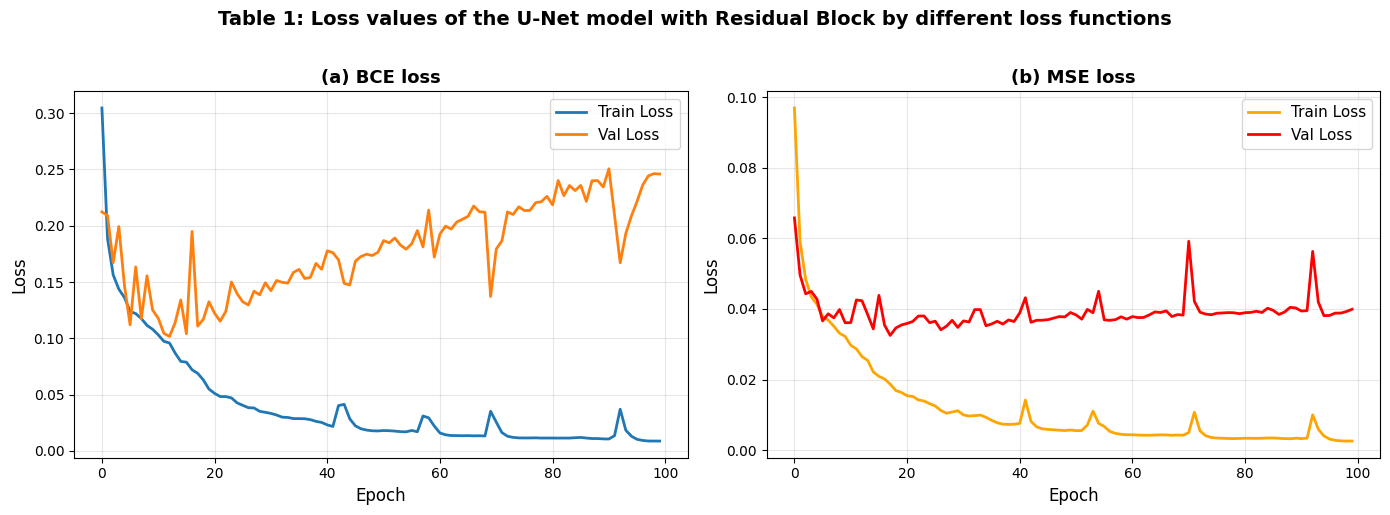

In [25]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(history['BCE']['train_loss'], label='Train Loss', linewidth=2)
axes[0].plot(history['BCE']['val_loss'], label='Val Loss', linewidth=2)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title('(a) BCE loss', fontsize=13, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

axes[1].plot(history['MSE']['train_loss'], label='Train Loss', linewidth=2, color='orange')
axes[1].plot(history['MSE']['val_loss'], label='Val Loss', linewidth=2, color='red')
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Loss', fontsize=12)
axes[1].set_title('(b) MSE loss', fontsize=13, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.suptitle('Table 1: Loss values of the U-Net model with Residual Block by different loss functions', 
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('table1_loss_curves.png', dpi=300, bbox_inches='tight')
plt.show()

In [26]:
test_results = {}

for loss_name, model in models_dict.items():
    model.eval()
    
    all_mae = []
    all_iou = []
    
    with torch.no_grad():
        for images, masks in tqdm(test_loader, desc=f'Evaluating {loss_name}'):
            images = images.to(device)
            masks = masks.to(device)
            
            outputs = model(images)
            
            mae, iou = calculate_metrics(outputs, masks)
            all_mae.append(mae)
            all_iou.append(iou)
    
    test_results[loss_name] = {
        'MAE': np.mean(all_mae),
        'IoU': np.mean(all_iou)
    }

results_df = pd.DataFrame(test_results).T
results_df.index.name = 'Loss function'

print("Table 2: MAE and IoU values on test dataset")
print(results_df.to_string())

results_df.to_csv('table2_metrics.csv')

Evaluating MSE: 100%|██████████| 583/583 [00:04<00:00, 129.41it/s]

Table 2: MAE and IoU values on test dataset
                    MAE       IoU
Loss function                    
BCE            4.794312  0.633509
MSE            4.914625  0.628674


In [27]:
def visualize_segmentation(models_dict, test_dataset, image_idx, save_name, title):
    image, mask = test_dataset[image_idx]
    
    fig, axes = plt.subplots(3, 3, figsize=(12, 12))
    axes[0, 0].imshow(image.squeeze().cpu().numpy(), cmap='gray')
    axes[0, 0].set_title('Original Image', fontsize=11, fontweight='bold')
    axes[0, 0].axis('off')
    
    axes[0, 1].axis('off')
    
    axes[0, 2].imshow(image.squeeze().cpu().numpy(), cmap='gray')
    axes[0, 2].set_title('Original Image', fontsize=11, fontweight='bold')
    axes[0, 2].axis('off')
    
    axes[1, 0].imshow(mask.squeeze().cpu().numpy(), cmap='gray')
    axes[1, 0].set_title('Ground-truth', fontsize=11, fontweight='bold')
    axes[1, 0].axis('off')
    
    axes[1, 1].axis('off')
    
    axes[1, 2].imshow(mask.squeeze().cpu().numpy(), cmap='gray')
    axes[1, 2].set_title('Ground-truth', fontsize=11, fontweight='bold')
    axes[1, 2].axis('off')
    
    loss_names = ['BCE', 'MSE']
    
    for idx, loss_name in enumerate(loss_names):
        model = models_dict[loss_name]
        model.eval()
        
        with torch.no_grad():
            pred = model(image.unsqueeze(0).to(device))
            pred = pred.squeeze().cpu().numpy()
        
        col_idx = idx * 2  
        axes[2, col_idx].imshow(pred, cmap='gray')
        axes[2, col_idx].set_title(f'Predicted infected area', fontsize=11, fontweight='bold')
        axes[2, col_idx].axis('off')
    
    
    axes[2, 1].axis('off')
    
    fig.text(0.25, 0.95, 'BCE loss', ha='center', fontsize=13, fontweight='bold')
    fig.text(0.75, 0.95, 'MSE loss', ha='center', fontsize=13, fontweight='bold')
    
    plt.suptitle(title, fontsize=14, fontweight='bold', y=0.98)
    plt.tight_layout(rect=[0, 0, 1, 0.94])
    plt.savefig(save_name, dpi=300, bbox_inches='tight')
    plt.show()
    
    return save_name


Generating Figure 1 (Image 181)...


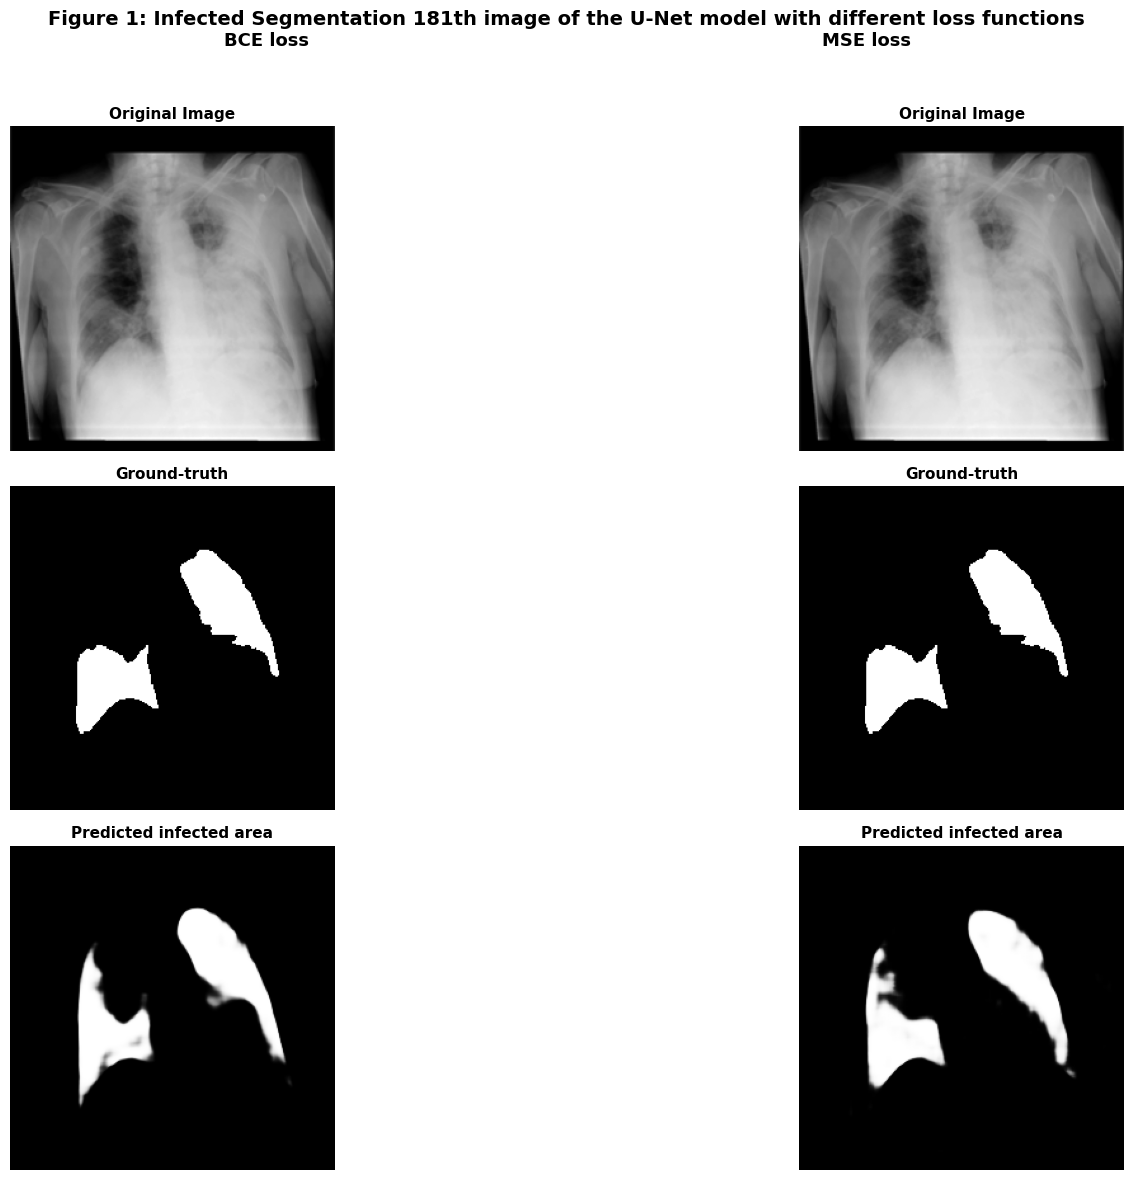


Generating Figure 2 (Image 182)...


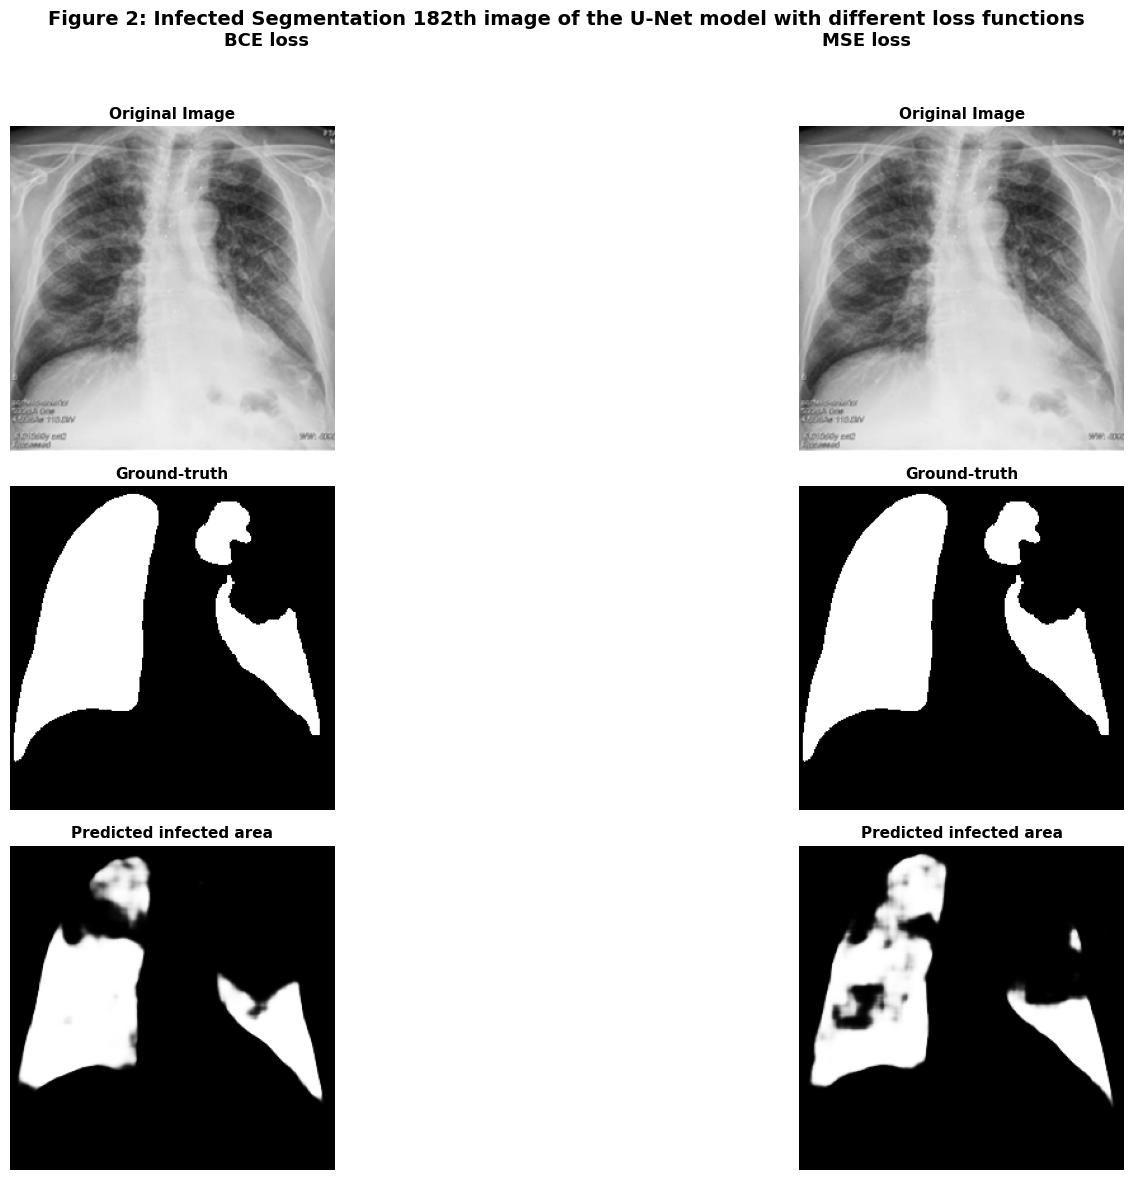


Generating Figure 3 (Image 184)...


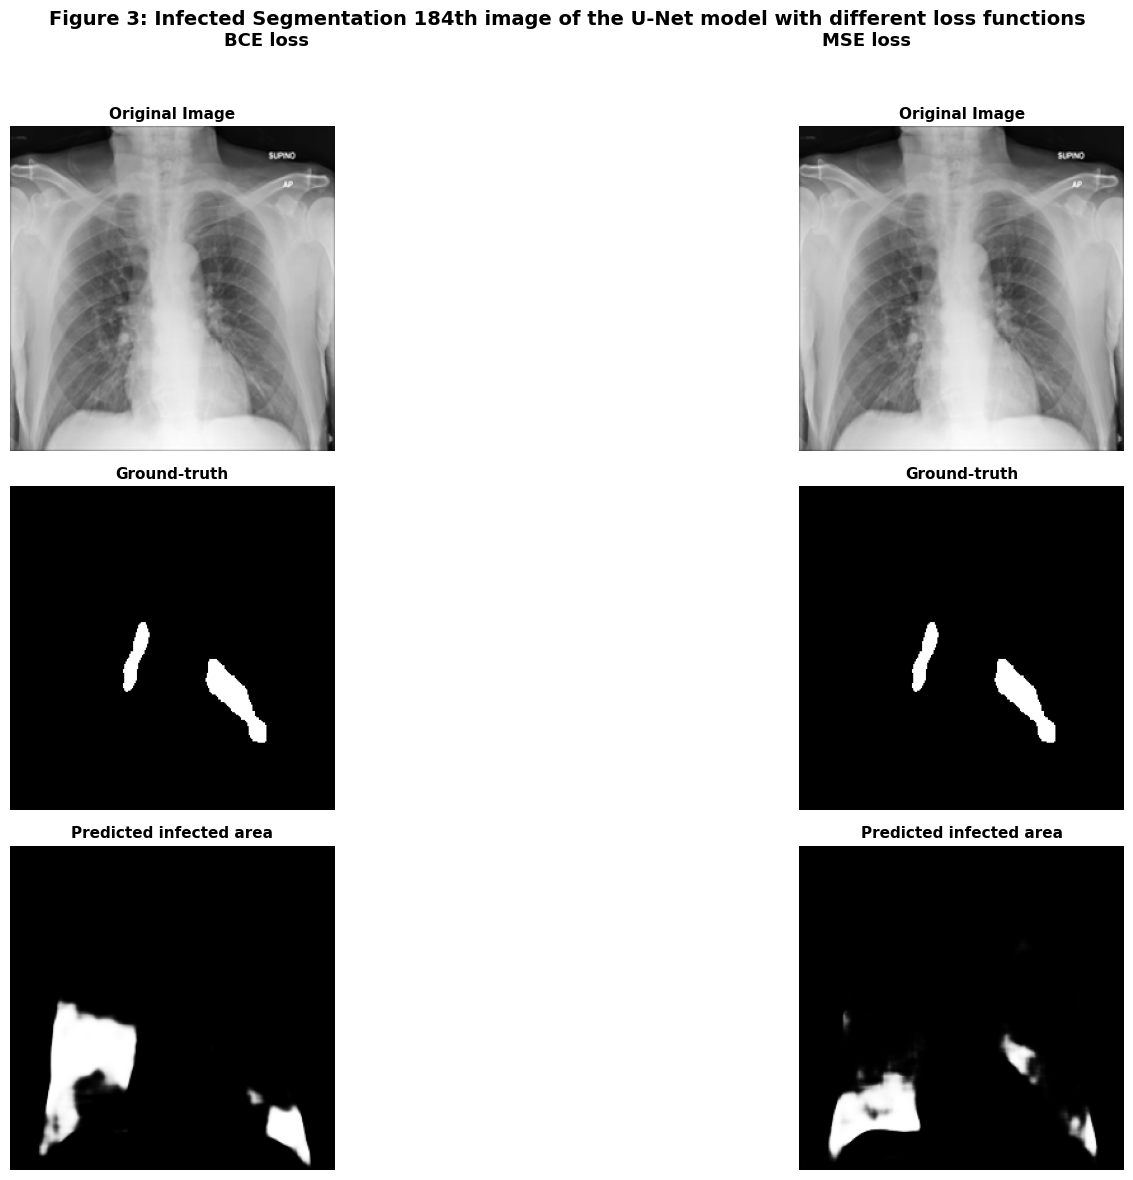

In [28]:
test_indices = [180, 181, 183]  
figure_numbers = [1, 2, 3]

saved_figures = []

for test_idx, fig_num in zip(test_indices, figure_numbers):
    actual_image_num = test_idx + 1  
    
    print(f'\nGenerating Figure {fig_num} (Image {actual_image_num})...')
    
    save_name = f'figure{fig_num}_infected_segmentation_{actual_image_num}th.png'
    title = f'Figure {fig_num}: Infected Segmentation {actual_image_num}th image of the U-Net model with different loss functions'
    
    visualize_segmentation(models_dict, test_dataset, test_idx, save_name, title)
    saved_figures.append((fig_num, save_name, actual_image_num))